In [1]:
import os

import time

import jax
import jax.numpy as jnp
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

import numpy as np
from scipy.linalg import eigh

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import equinox

import pandas as pd

from jax import config
config.update("jax_enable_x64", False)

ModuleNotFoundError: No module named 'numpyro'

In [2]:
jax.devices()

[cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]

Heat equation is solved using the FDM method. Code for solving the heat equation has been adapted from: https://github.com/inductiva/blog_code_snippets

In [3]:
def compute_dimension_delta(dimension_range, dimension_num_points):
    """Computes the interval between points for a given dimension.

    Args:
        dimension_range: domain extension in the dimension considered
        dimension_num_points: number of points used in the regular
        discretization of the dimension considered

    Returns:
        Interval between points in the provided dimension
    """

    delta = dimension_range / (dimension_num_points - 1)
    return delta

In [4]:
def compute_fdm_stability_constants(diff_coef, delta_t, delta_x, delta_y):
    """Computes FDM stability constants for the chosen sampling

    Args:
        diff_coef: diffusion coefficient of the heat PDE
        delta_t: interval between timesteps considered
        delta_x: interval between spatial points along the x-axis
        delta_y: interval between spatial points along the y-axis

    Returns:
        Stability constants of the instance provided if it is stable. Otherwise,
        raises an Exception.
    """

    alpha = diff_coef * delta_t / delta_x ** 2
    beta = diff_coef * delta_t / delta_y ** 2

    return alpha, beta

In [5]:
def fdm_is_unstable(alpha, beta):
    """Checks if the FDM stability condition is not verified.

    The stability of this method is guaranteed if alpha + beta <= 0.5
    (see analysis for the 2D Heat PDE:
    https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/heat.pdf
    - pages 11/12)

    Args:
        alpha: fdm stability constant referent to the x-axis
        beta: fdm stability constant referent to the y-axis

    Returns:
        Boolean that answers if the FDM stability condition is not verified for
        the FDM stability constants provided
    """

    return alpha + beta > .5

In [6]:
def initialize_plate(num_x_points, num_y_points):
    """Initializes the plate where we'll observe heat diffusion

    Args:
        num_x_points: Number of points to be considered in the x-axis
        num_y_points: Number of points to be considered in the y-axis

    Returns:
        Matrix with shape (num_x_points, num_y_points)
    """

    return np.empty((num_x_points, num_y_points))

In [7]:
def set_initial_conditions(u, initial_temp):
    """Sets the initial condition in the whole plate

    Args:
        u: Plate where we are going to impose the initial condition
        initial_temp: Temperature of the initial points (imposed by the initial
        condition)

    Returns:
        Matrix filled with the initial points temperature in every point
    """

    #u.fill(initial_temp)
    u = jax.random.normal(jax.random.PRNGKey(0), u.shape)
    u = np.asarray(u)
    
    return np.copy(u)

In [8]:
def set_canonical_boundary_conditions(u, hot_temp, cold_temp):
    """Sets the canonical boundary conditions for the setting considered

    Args:
        u: Plate where we are going to impose the boundary conditions
        hot_temp: Temperature of the hot edge of the plate
        cold_temp: Temperature of the cold edges of the plate

    Returns:
        Matrix filled with the boundary conditions imposed
    """

    u = u.at[:, 0].set(cold_temp)
    u = u.at[0, :].set(cold_temp)
    u = u.at[:, -1].set(cold_temp)
    u = u.at[-1, :].set(hot_temp)

    return u

In [9]:
@jax.jit
def fdm_advance_time_jax(u, alpha, beta):
    """Advances the simulation by one timestep, via FDM using JAX

    Args:
        u: grid state at instant i
        alpha: fdm stability constant referent to the x-axis
        beta: fdm stability constant referent to the y-axis

    Returns:
        Grid state at instant i+1
    """

    # Vectorized FDM
    next_u = jnp.array(u)

    # compute u(y,x) for the next instant t_{i+1}, using FDM
    vectorized_forward_step = alpha * (jnp.roll(u, 1, axis=0) +
                                        jnp.roll(u, -1, axis=0)) + \
                                beta * (jnp.roll(u, 1, axis=1) +
                                        jnp.roll(u, -1, axis=1)) + \
                                (1 - 2 * alpha - 2 * beta) * u
    next_u = next_u.at[1:-1, 1:-1].set(vectorized_forward_step[1:-1, 1:-1])

    return next_u

# Karhunen-Loeve fun

In [10]:
# Diffusion coefficient of the heat PDE.
diff_coef = 0.5
# Plate_length. Side length of the considered plate.
plate_length = 10.0
# Duration of the simulation 
t_final = 1.0
# Temperature of the hot edge of the plate.
hot_edge_temp = 0.
# Temperature of the cold edge of the plate.
cold_edge_temp = 0.
# Number of timeframes
num_timeframes = 1000
# Number x and y points in FDM.
n_quad = 64
# Pooling size
n_pool = 8
# Pooling stride
stride = 8

In [11]:
def distance_matrix(x, y):
    return jnp.sqrt(jnp.sum(jnp.abs(x[:, jnp.newaxis, :] - y[jnp.newaxis, :, :]) ** 2, axis=-1))


class SquaredExponential:
    def __init__(self, coords, mkl, lamb):
        """
        This class sets up a random process
        on a grid and generates
        a realisation of the process, given
        parameters or a random vector.
        """

        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb

        self.assemble_covariance_matrix()

    def assemble_covariance_matrix(self):
        """
        Create a snazzy distance-matrix for rapid
        computation of the covariance matrix.
        """
        dist = distance_matrix(self.coords, self.coords)

        # Compute the covariance between all
        # points in the space.
        self.cov = jnp.exp(-0.5 * dist**2 / self.lamb**2)

    def plot_covariance_matrix(self):
        """
        Plot the covariance matrix.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(self.cov, cmap="binary")
        plt.colorbar()
        plt.show()

    def compute_eigenpairs(self):
        """
        Find eigenvalues and eigenvectors using Arnoldi iteration.
        """
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))

        order = jnp.flip(jnp.argsort(eigvals))
        self.eigenvalues = jnp.asarray(eigvals[order])
        self.eigenvectors = jnp.asarray(eigvecs[:, order])

    def generate(self, parameters=None, key=None):
        """
        Generate a random field, see
        Scarth, C., Adhikari, S., Cabral, P. H.,
        Silva, G. H. C., & Prado, A. P. do. (2019).
        Random field simulation over curved surfaces:
        Applications to computational structural mechanics.
        Computer Methods in Applied Mechanics and Engineering,
        345, 283–301. https://doi.org/10.1016/j.cma.2018.10.026
        """

        if parameters is None:
            if key is None:
                key = jax.random.PRNGKey(0)
            self.parameters = jax.random.normal(key, shape=(self.mkl,))
        else:
            self.parameters = jnp.array(parameters).flatten()

        self.random_field = jnp.linalg.multi_dot(
            (self.eigenvectors, jnp.sqrt(jnp.diag(self.eigenvalues)), self.parameters)
        )

    def plot(self, lognormal=True):
        """
        Plot the random field.
        """

        if lognormal:
            random_field = self.random_field
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)
        else:
            random_field = jnp.exp(self.random_field)
            contour_levels = jnp.linspace(min(random_field), max(random_field), 20)

        plt.figure(figsize=(12, 10))
        plt.tricontourf(
            self.coords[:, 0],
            self.coords[:, 1],
            random_field,
            levels=contour_levels,
            cmap="plasma",
        )
        plt.colorbar()
        plt.show()


class Matern52(SquaredExponential):
    def assemble_covariance_matrix(self):
        """
        This class inherits from RandomProcess and creates a Matern 5/2 covariance matrix.
        """

        # Compute scaled distances.
        dist = jnp.sqrt(5.0) * distance_matrix(self.coords, self.coords) / self.lamb

        # Set up Matern 5/2 covariance matrix.
        self.cov = (1 + dist + dist**2 / 3) * jnp.exp(-dist)

In [12]:
def heat_body_fn(i, val):
    u, alpha, beta = val
    u = fdm_advance_time_jax(u, alpha, beta)
    return (u, alpha, beta)

def heat_solver(u, alpha, beta, delta_t, num_timeframes):
    """Runs the numerical simulation throughout time

    Args:
        u: initial state of the grid where the fdm is going to run
        alpha: fdm stability constant referent to the x-axis
        beta: fdm stability constant referent to the y-axis
        delta_t: time interval between fdm iterations
        num_timeframes: number of fdm iterations
    Returns:
        Final temperature field.
    """
    u = jax.lax.fori_loop(0, num_timeframes, heat_body_fn, (u, alpha, beta))[0]
    return u

jax.jit(heat_solver, static_argnums=(4,))

<PjitFunction of <function heat_solver at 0x7f6897001ea0>>

In [13]:
class Heat:
    """
    Class for heat equation inverse problem involving initial temperature field and diffusivity.
    """

    def __init__(self, 
                 u_function: callable, 
                 diff_coef: float, 
                 n_quad: int, 
                 n_pool: int, 
                 stride: int,
                 num_timeframes: int = num_timeframes,
                 plate_length: float = plate_length,
                 hot_edge_temp: float = hot_edge_temp,
                 cold_edge_temp: float = cold_edge_temp,
                 t_final: float = t_final
                 ):

        # Set the function describing the distribution of subsurface density.
        self.u_function = u_function

        # Diffusivity constant for heat equation.
        self.diff_coef = diff_coef

        # Set the quadrature degree along one dimension.
        self.n_quad = n_quad
        
        # Set the quadrature points.
        x = jnp.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = jnp.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = jnp.meshgrid(self.tx, self.ty)

        # Size of pooling kernel along one axis.
        self.n_pool = n_pool
        
        # Stride of the pooling kernel.
        self.stride = stride
        
        # Stride of pooling kernel.
        self.pool = equinox.nn.AvgPool2d(kernel_size=(self.n_pool, self.n_pool), stride=self.stride)
        
        # Solver parameters
        self.num_timeframes = num_timeframes
        self.plate_length = plate_length
        self.hot_edge_temp = hot_edge_temp
        self.cold_edge_temp = cold_edge_temp
        self.t_final = t_final

        # Evaluate the initial temperature field.
        self.u_initial = self.u_function(TX, TY)
        
        # Compute spatial grid spacings, time step and relevant problem variables
        self.delta_t = compute_dimension_delta(self.t_final, self.num_timeframes)
        self.delta_x = compute_dimension_delta(self.plate_length, self.n_quad)
        self.delta_y = compute_dimension_delta(self.plate_length, self.n_quad)

        # Check and compute FDM stability constants for the instance provided
        self.alpha, self.beta = compute_fdm_stability_constants(self.diff_coef, 
                                                                self.delta_t, 
                                                                self.delta_x, 
                                                                self.delta_y)

        if fdm_is_unstable(self.alpha, self.beta):
            raise Exception(
                f"Stability not guaranteed (alpha + beta > 0.5): alpha = {self.alpha},"
                f"beta = {self.beta}")
        print(f"Stability guaranteed: alpha = {self.alpha}; beta = {self.beta}")

        # Set canonical boundary conditions.
        self.u_initial = set_canonical_boundary_conditions(self.u_initial,
                                                           self.hot_edge_temp,
                                                           self.cold_edge_temp)

        # Compute the temperature field at t_final
        self.u_final = heat_solver(self.u_initial, self.alpha, self.beta, self.delta_t, self.num_timeframes)
        
        # Generate noiseless signal
        self.g = self.pool(self.u_final[None, :, :])[0, :, :]

    def plot_model(self):

        # Plot the density and the signal.
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes[0].set_title("Initial temperature field")
        f = axes[0].imshow(
            self.u_initial,
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="icefire",
        )
        fig.colorbar(f, ax=axes[0])
        axes[1].set_title("Signal temperature field")
        g = axes[1].imshow(
            self.g,
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="icefire"
        )
        fig.colorbar(g, ax=axes[1])
        plt.show()

    def plot_kernel(self):

        # Plot the kernel.
        plt.figure(figsize=(8, 6))
        plt.imshow(self.K, cmap="plasma")
        plt.colorbar()
        plt.show()

In [14]:
x = jnp.linspace(0, 1, n_quad + 1)
tx = (x[1:] + x[:-1]) / 2
y = jnp.linspace(0, 1, n_quad + 1)
ty = (y[1:] + y[:-1]) / 2
TX, TY = jnp.meshgrid(tx, ty)
T_coords = jnp.c_[TX.ravel(), TY.ravel(), np.zeros(n_quad ** 2)]

kxx = SquaredExponential(T_coords, 200, 0.1)
kxx.compute_eigenpairs()

/tmp/ipykernel_116077/191944427.py:52: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))


In [15]:
theta = jax.random.normal(jax.random.PRNGKey(1929), shape=(200,))
#kxx.generate(theta)

@jax.jit
def jit_gen(theta, eigenvalues, eigenvectors):
    parameters = jnp.array(theta).flatten()
    random_field = jnp.linalg.multi_dot((eigenvectors, jnp.sqrt(jnp.diag(eigenvalues)), parameters))
    return random_field

#kxx.jit_gen(theta)

def random_init_field(TX, TY):
    field = jit_gen(theta, kxx.eigenvalues, kxx.eigenvectors)
    return field.reshape((n_quad, n_quad))

In [16]:
def f(TX, TY):
    f = np.exp(-((TX - 0.5) ** 2 + (TY - 0.5) ** 2) / 0.05)
    f = f / f.max()
    return f

In [17]:
model_true = Heat(random_init_field, diff_coef, n_quad, n_pool, stride)
x1 = model_true.g

Stability guaranteed: alpha = 0.019864864864864867; beta = 0.019864864864864867


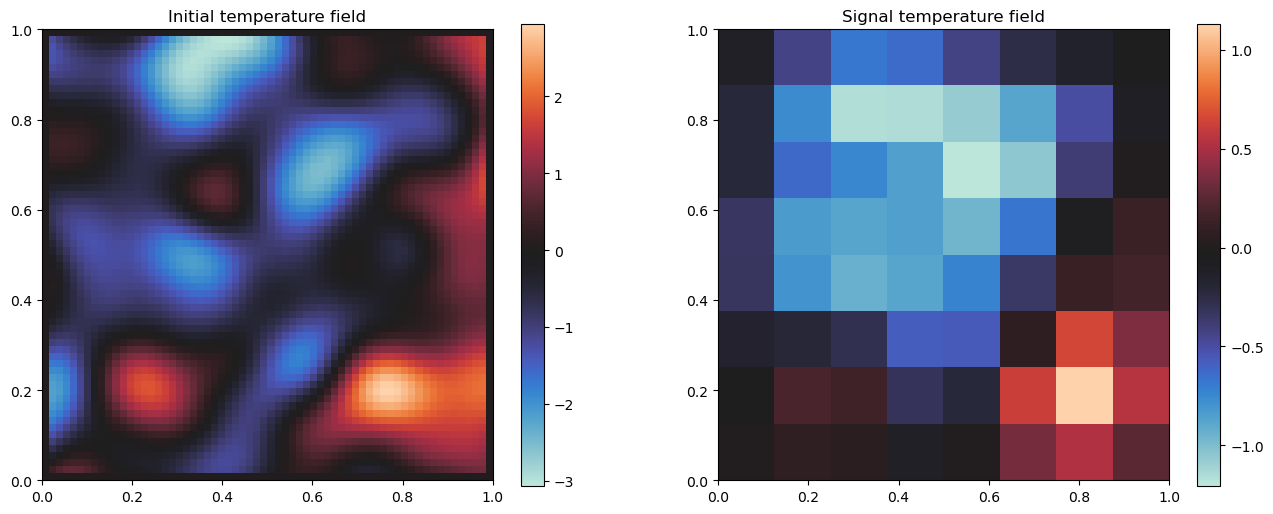

In [18]:
model_true.plot_model()

In [19]:
class Heat_Forward(Heat):
    """
    Forward model class for the heat equation
    """

    def __init__(self,
                 n_quad: int, 
                 n_pool: int, 
                 stride: int,
                 num_timeframes: int = num_timeframes,
                 plate_length: float = plate_length,
                 hot_edge_temp: float = hot_edge_temp,
                 cold_edge_temp: float = cold_edge_temp,
                 t_final: float = t_final
                ):
        
        # Set the quadrature degree along one dimension.
        self.n_quad = n_quad
        
        # Set the quadrature points.
        x = jnp.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = jnp.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = jnp.meshgrid(self.tx, self.ty)
        self.T_coords = jnp.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad ** 2)]

        # Size of pooling kernel along one axis.
        self.n_pool = n_pool
        
        # Stride of the pooling kernel.
        self.stride = stride
        
        # Stride of pooling kernel.
        self.pool = equinox.nn.AvgPool2d(kernel_size=(self.n_pool, self.n_pool), stride=self.stride)
        
        # Solver parameters
        self.num_timeframes = num_timeframes
        self.plate_length = plate_length
        self.hot_edge_temp = hot_edge_temp
        self.cold_edge_temp = cold_edge_temp
        self.t_final = t_final
        
        # Compute spatial grid spacings, time step and relevant problem variables
        self.delta_t = compute_dimension_delta(self.t_final, self.num_timeframes)
        self.delta_x = compute_dimension_delta(self.plate_length, self.n_quad)
        self.delta_y = compute_dimension_delta(self.plate_length, self.n_quad)

    def set_random_process(self, random_process, lamb, mkl):

        # Set the number of KL modes.
        self.mkl = mkl

        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(self.T_coords, self.mkl, lamb)
        self.random_process.compute_eigenpairs()

    def solve(self, diff_coeff, mean, stdev, theta):

        # Internalise the Random Field parameters
        self.parameters = theta

        # Create a realisation of the random process, given the parameters.
        #self.random_process.generate(self.parameters)
        random_field = jit_gen(self.parameters, self.random_process.eigenvalues, self.random_process.eigenvectors)

        # Set the density.
        self.u_initial = mean + stdev * random_field
        self.u_initial = self.u_initial.reshape(self.n_quad, self.n_quad)
        
        # Check and compute FDM stability constants for the instance provided
        self.alpha, self.beta = compute_fdm_stability_constants(diff_coef, 
                                                                self.delta_t, 
                                                                self.delta_x, 
                                                                self.delta_y)
        
        # Compute the temperature field at t_final
        self.u_final = heat_solver(self.u_initial, self.alpha, self.beta, self.delta_t, self.num_timeframes)
        
        # Generate noiseless signal
        self.g = self.pool(self.u_final[None, :, :])[0, :, :]

    def get_data(self):

        # Get the data vector.
        return self.g.ravel()

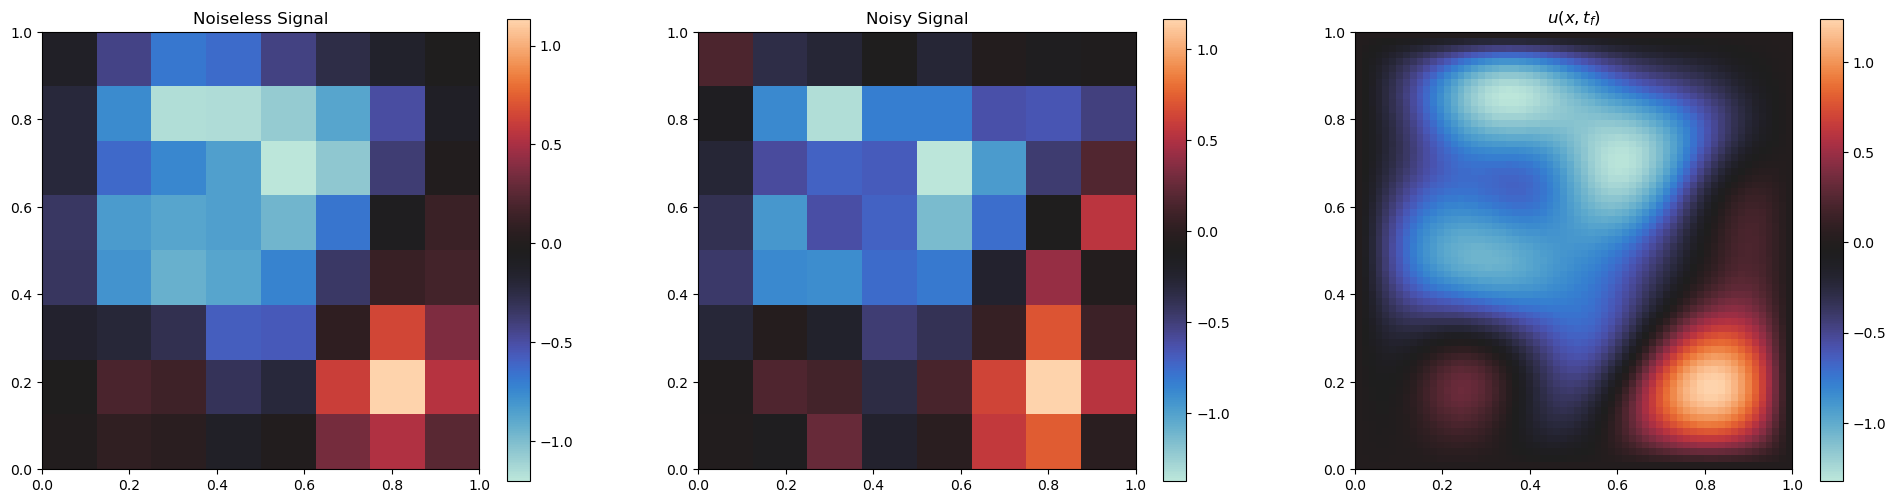

In [20]:
# Add noise to the data.
# Leave like this so we have the same data!
n_data = 8
noise_level = 0.2

noise = jax.random.normal(jax.random.PRNGKey(100), shape=(n_data ** 2,)) * noise_level
obs_cov = noise_level ** 2 * jnp.eye(n_data ** 2)

data = model_true.g.ravel() + noise

# Plot the density and the signal.
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

axes[0].set_title("Noiseless Signal")
g = axes[0].imshow(model_true.g,
                   extent=(0, 1, 0, 1),
                   origin="lower",
                   cmap="icefire")
fig.colorbar(g, ax=axes[0])

axes[1].set_title("Noisy Signal")
d = axes[1].imshow(data.reshape(n_data, n_data), 
                   extent=(0, 1, 0, 1), 
                   origin="lower", 
                   cmap="icefire")
fig.colorbar(d, ax=axes[1])

axes[2].set_title(r"$u(x, t_f)$")
f = axes[2].imshow(model_true.u_final, 
                   extent=(0, 1, 0, 1), 
                   origin="lower", 
                   cmap="icefire")
fig.colorbar(f, ax=axes[2])
plt.show()

In [21]:
lamb = 0.1
mkl = 100

hsolver = Heat_Forward(n_quad=64, n_pool=8, stride=8)
hsolver.set_random_process(SquaredExponential, lamb, mkl)

@jax.jit
def hsolve(diff_coeff, mean, stdev, theta, solver=hsolver):
    solver.solve(diff_coeff, mean, stdev, theta)
    return solver.get_data()

/tmp/ipykernel_116077/191944427.py:52: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))


In [22]:
np.savetxt('./true_initial_temperature_field_jupyter.txt', model_true.u_initial)
np.savetxt('./model_data_jupyter.txt', data)

# Numpyro model

In [23]:
def numpyro_heat_model(data, obs_cov):
    diff_coeff = numpyro.sample('diff_coeff', dist.HalfNormal(0.5))
    mu = numpyro.sample('mu', dist.Normal(0.0, 0.1))
    stdev = numpyro.sample('stdev', dist.HalfNormal(1.0))
    theta = numpyro.sample('theta', dist.Normal(jnp.zeros(mkl), jnp.ones(mkl)))
    obs_sim = hsolve(diff_coeff, mu, stdev, theta)
    llk = numpyro.sample('llk', dist.Normal(obs_sim, noise_level), obs=data)

In [ ]:
def run_inference(model, num_warmup, num_samples, num_chains, rng_key, data, cov):
    init_strategy = init_to_value(
            values={"diff_coeff": 0.5, 
                    "mu": 0.0, 
                    "stdev": 1.0})
    kernel = NUTS(model, max_tree_depth=7, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=True,
        chain_method='vectorized',
    )
    mcmc.run(rng_key, data, cov)
    mcmc.print_summary()
    return mcmc, mcmc.get_samples()

In [ ]:
mcmc, samples = run_inference(numpyro_heat_model, 4000, 1000, 4, jax.random.PRNGKey(0), data, obs_cov)